# Define the model

$$
\begin{align*}
(\widehat{S}_{1k},...,\widehat{S}_{Ik})^T &\sim N((S_{1k}, . . . , S_{Ik})^T, \hat{\Sigma}_k )\\
    S_{ik} &\sim \delta_i P_0 + (1-\delta_i) (2M_i - 1) N(\beta_k, \sigma_k^2)\\
    \beta_k &\sim N(\nu, \tau^2)\\
    M_i &\sim Bern(\phi_M)\\
    \delta_i &\sim Bern(\phi_\delta)\\
    \sigma_k^2 &\sim InvGamma(1, 0.001)\\
    \tau^2 &\sim InvGamma(1, 0.001)\\
    \nu &\sim N(0, 100)\\
\end{align*}
$$

Optionally, we can place hierarchical priors on $\phi_\delta, \phi_M$:

$$
\begin{align*}
    \phi_M &\sim Beta(u_M, v_M)\\
    \phi_\delta &\sim Beta(u_\delta, v_\delta)
\end{align*}
$$

I find that parametrizing $\beta_k$ with an unconstrained Normal improved mixing and convergence of the MCMC chains substantially. This results in multi-modal posterior distributions for $\{\beta_k\}_{k=1}^K$ and $\{M_i\}_{i=1}^I$. We can post-process to identify these parameters:

$$
\begin{align*}
    M_{ik} &= 0.5[(2M_i - 1)sign(\beta_k) + 1]\\
    \beta_k &= |\beta_k|
\end{align*}
$$

In [7]:
import numpy as np
import seaborn as sns
from scipy.stats import bernoulli, halfnorm, norm, gamma, invgamma, cauchy
from scipy.special import expit, logit
import pandas as pd
import matplotlib.pyplot as plt
import math

In [2]:
import pymc as pm
print(f"Running on PyMC v{pm.__version__}")
import aesara.tensor as at
import pytensor.tensor as pt
from scipy.linalg import block_diag, cholesky
import arviz as az

Running on PyMC v5.1.2


In [3]:
# Initialize random number generator
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)

In [4]:
# Remove constraints that beta is non-negative so the sampler explores the space
# more efficiently and removes divergences in Hamiltonian MC
# Post-process: 
#      m_ik = ((2m_i-1)*sign(beta_k) + 1) / 2
#      beta_k = abs(beta_k)

# ate: I \times K matrix of ATE estimates
# se: I \times K matrix of s.e. of the ATE estimates
# phi_d, phi_m: Empirical Bayes estimates of phi_d, phi_m; if None places hierarchical priors on them
# TODO: update code to take se as covariance matrix inputs
def get_model_unconstrained(ate, se, x=None, phi_d=None, phi_m=None, 
                            nu=None, tau=None, 
                            alpha_d=1, beta_d=1, alpha_m=1, beta_m=1,
                            alpha_sigma=0.001, beta_sigma=0.001
                           ):
    # Set the number of NCOs
    I = ate.shape[0]
    
    # Set the number of scenarios/treatment contrasts
    K = ate.shape[1]

    # Declare the dimensions of the data and parameters. 
    # This helps with organizing the indices of the posterior samples
    coords_nco = ['nco_'+str(i) for i in range(I)]
    coords_setting = ['setting_'+str(i) for i in range(K)]
    coords = {'nco': coords_nco, 'setting': coords_setting}
    
    # Initialize a model
    model = pm.Model(coords=coords)
    with model:
        
        # State input data as shared variables. Not sure if this is neccesary, but seems to be recommended in the documentation
        Y_t = pm.MutableData('Y', ate, dims=('nco', 'setting'))
        Sigma_t = pm.MutableData('Sigma', se, dims=('nco', 'setting')) # TODO: update to include covariances
#         Sigma_t = pm.MutableData('Sigma', cov, dims=('nco', 'nco'))
        x_t = pt.ones(I) #pm.MutableData('x', x, dims='nco') # currently fix to a vector of ones for group-mean estimation

        # Priors for unknown model parameters
        if nu is None:
            nu_t = pm.Normal('nu', mu=0, sigma=100)
        else:
            nu_t = nu
        if tau is None:
            tau_t = pm.InverseGamma('tau', 0.001, 0.001)
        else:
            tau_t = tau
        if phi_d is None: 
            phi_d_t = pm.Beta('phi_d', alpha=alpha_d, beta=beta_d)
        else:
            phi_d_t = phi_d
        if phi_m is None: 
            phi_m_t = pm.Beta('phi_m', alpha=alpha_m, beta=beta_m)
        else:
            phi_m_t = phi_m
        beta_t = pm.Normal('beta', mu=nu_t, sigma=pt.sqrt(tau_t), size=K, dims='setting')
#         sigma_t = pm.InverseGamma('sigma', alpha=alpha_sigma, beta=beta_sigma, size=K, dims='setting')
        sigma_t = pm.HalfCauchy('sigma', beta=25, size=K, dims='setting')
        delta_t = pm.Bernoulli('delta', p=phi_d_t, size=I, dims='nco')
        m_t = pm.Bernoulli('m', p=phi_m_t, size=I, dims='nco')
        # This seems to work better than the matrix normal prior
        slap_t = pm.Normal('slap', mu=pt.outer((2*m_t-1), beta_t), sigma=pt.outer(pt.ones(I), pt.sqrt(sigma_t)), dims=('nco', 'setting'))
        mu_t = pm.Deterministic('mu', pt.outer((1-delta_t), pt.ones(K))*slap_t, dims=('nco', 'setting'))

        # Likelihood model
        # TODO: make this a truncated likelihood -2 to 2?
        Y_obs = pm.Normal('Y_obs', mu=mu_t, sigma=Sigma_t, observed=Y_t, dims=('nco', 'setting'))
#         Y_obs = pm.MvNormal('Y_obs', mu=mu_t, cov=Sigma_t, observed=Y_t, dims=('nco', 'setting'))

        # # Compound sampling step using MH + MWG + NUTS
        # if (mh_step):
        #     step = pm.CompoundStep([
        #                             pm.BinaryGibbsMetropolis([delta_t, m_t], transit_p=.42),
        #                             pm.Metropolis([beta_t, slap_t, sigma_t, tau_t])
        #                             ])
        #     return (model, step)
    
    return model

# Simulation

Simulate data from the following model but include 11 NCOs but no outcome with causal associations with treatment A:

<div>
<img src="dag-1.png" width="500"/>
</div>

Since there is no observed confounder, we can estimate the average causal effects and biases using difference in means or ratios of means. One NCO is excluded from fitting the model to use for checking the posterior predictive.

## Simulate data

In [5]:
# Set random seed
np.random.seed(12)
# Set number of observations
n = 10000
# Set number of unobserved confounders
p_u = 2
# Set number of treatment groups
n_a = 2
# Set number of scenarios/treatment contrasts
K = math.comb(n_a, 2)

# Generate latent space regression coefficients of U on A
alpha_u = np.array([0.2, 0.3]) #np.random.uniform(0.1, 0.3, size=p_u)  # effect of U on treatment assigment A

# Generate unobserved confounder from standard normal
U = np.random.normal(size=(n, p_u))
# Generate another dataset with 1M samples to approximate the truth
U_1m = np.random.normal(size=(1000000, p_u))

# Define the treatment groups by discretizing the latent A
A = np.matmul(U, alpha_u)
A_1m = np.matmul(U_1m, alpha_u)

In [6]:
# For binary treatment, use logistic model
A_obs = bernoulli.rvs(p=expit(A))
A_obs_1m = bernoulli.rvs(p=expit(A_1m))

In [16]:
# Define number of NCOs
I = 30
# Define a sample of outcomes for validation
n_y = 300 

# Define the effects of U on the NCOs in latent space
beta_u_low = 0.2
beta_u_high = 0.5
theta_u = np.random.uniform(beta_u_low, beta_u_high, size=(p_u, I))
theta_y = np.random.uniform(beta_u_low, beta_u_high, size=(p_u, n_y))

# Randomly zero-out the effects
phi_delta = 0.3
theta_u *= np.random.choice([0, 1], size=(p_u, I), p=[phi_delta, 1-phi_delta])
theta_y *= np.random.choice([0, 1], size=(p_u, n_y), p=[phi_delta, 1-phi_delta])

# Randomly shuffle the sign of the effects with probability 0.5
phi_m = 0.7
theta_u *= np.random.choice([-1, 1], size=(p_u, I), p=[phi_m, 1-phi_m])
theta_y *= np.random.choice([-1, 1], size=(p_u, n_y), p=[phi_delta, 1-phi_delta])

# Define the outcome proportion through intercept term in logistic regression
p_nco = logit(np.linspace(0.02, 0.9, num=I))
# Define the outcome proportion through intercept term in logistic regression
p_y = logit(np.concatenate([np.repeat(0.05, n_y / 2), np.repeat(0.85, n_y / 2)]))

# Generate binary NCOs
N_1m = bernoulli.rvs(p=expit(np.outer(np.ones(1000000), p_nco) + np.matmul(U_1m, theta_u))) # use large sample of 1M observations to approx true bias
N = bernoulli.rvs(p=expit(np.outer(np.ones(n), p_nco) + np.matmul(U, theta_u)))

In [20]:
# Outcome proportions of the NCOs are all around 0.5
N.mean(axis=0)

array([0.0192, 0.0512, 0.092 , 0.1162, 0.1566, 0.1701, 0.203 , 0.2477,
       0.2774, 0.3105, 0.3262, 0.3646, 0.3908, 0.4182, 0.4455, 0.4795,
       0.5185, 0.528 , 0.5622, 0.5901, 0.6183, 0.6575, 0.6844, 0.7061,
       0.7353, 0.7613, 0.7971, 0.8254, 0.8686, 0.8915])

In [23]:
# Calculate NCO bias estimates
bias_N = np.mean(N[A_obs == 1,:], axis=0) / np.mean(N[A_obs == 0,:], axis=0)
# Reshape into a (n, 1) matrix
bias_N = np.expand_dims(bias_N, 1)

### Generate outcomes 
#### First way
To see if distribution of bias changes as the treatment effect increases

In [9]:
# # Generate n_y binary outcomes, all having the same treatment effect
# beta = [0, 0.25, 0.7] # generate three sets of outcomes with different treatment effect size
# Y_0 = []
# Y_1 = []
# Y = []
# preds_0 = np.column_stack((U_1m, np.zeros(len(U_1m))))
# preds_1 = np.column_stack((U_1m, np.ones(len(U_1m))))
# for b in beta:
#     b_tmps = np.row_stack((theta_y, np.repeat(b, n_y)))
#     Y_1.append(bernoulli.rvs(p=expit(1 + np.matmul(preds_1, b_tmps))))
#     Y_0.append(bernoulli.rvs(p=expit(1 + np.matmul(preds_0, b_tmps))))
#     Y.append(bernoulli.rvs(p=expit(1 + np.matmul(np.column_stack((U_1m, A_obs_1m)), b_tmps))))
    
# # Calculate true treatment effects and true biases
# bias_N = np.mean(N[A_obs == 1,:], axis=0) / np.mean(N[A_obs == 0,:], axis=0)
# bias_N_true = np.mean(N_1m[A_obs_1m == 1,:], axis=0) / np.mean(N_1m[A_obs_1m == 0,:], axis=0)
# bias_Y_true = []
# effect_Y_true = []
# for i in range(len(beta)):
#     # true effect size using counterfactual outcomes
#     effect_tmp = np.mean(Y_1[i], axis=0) / np.mean(Y_0[i], axis=0)#np.mean(Y_1[i] - Y_0[i], axis=0)
#     effect_Y_true.append(effect_tmp)
#     # observed effect size that is biased
#     bias_tmp = np.mean(Y[i][A_obs_1m == 1,:], axis=0) / np.mean(Y[i][A_obs_1m == 0,:], axis=0)
#     # calculate the bias on the log RR scale: lRRbias = lRRobs - lRRtrue is equivalent to exp(lbias) = RRobs / RRtrue
#     bias_tmp /= effect_tmp
#     bias_Y_true.append(bias_tmp)

In [10]:
# # Plot the true treatment effects and true biases
# fig, axs = plt.subplots(1, len(beta) + 1, figsize=(13, 4))
# axs[0].hist(bias_N_true, bins=20, color='blue')
# axs[0].set_title('Biases of NCO')
# title_txt = ['no', 'small', 'large']
# for i, b in enumerate(beta):
#     axs[i+1].hist(bias_Y_true[i], bins=20, color='blue')
#     axs[i+1].hist(effect_Y_true[i], color='green')
#     axs[i+1].set_title('Biases of Y with ' + title_txt[i] + ' effect')
# fig.suptitle('Histograms of biases on RR scale')
# plt.show()

As seen above, the effect size doesn't effect the size of the bias. Is this only true for linear relationship though? 

#### Second way

Randomly sample the treatment effects for all generated outcomes

In [12]:
# Generate n_y binary outcomes with random treatment effects
beta = np.zeros(n_y) #np.random.uniform(0, 1, size=(n_y))
preds_0 = np.column_stack((U_1m, np.zeros(len(U_1m))))
preds_1 = np.column_stack((U_1m, np.ones(len(U_1m))))
b_tmps = np.row_stack((theta_y, beta))
# counterfactual Y under treatment
Y_1 = bernoulli.rvs(p=expit(np.outer(np.ones(1000000), p_y) + np.matmul(preds_1, b_tmps))) # 1M x n_y matrix
# counterfactual Y under control
Y_0 = bernoulli.rvs(p=expit(np.outer(np.ones(1000000), p_y) + np.matmul(preds_0, b_tmps)))
# observed Y
Y = bernoulli.rvs(p=expit(np.outer(np.ones(1000000), p_y) + np.matmul(np.column_stack((U_1m, A_obs_1m)), b_tmps)))

In [13]:
# Calculate true treatment effects and true biases on RR scale
# true effect size using counterfactual outcomes
effect_Y_true = np.mean(Y_1, axis=0) / np.mean(Y_0, axis=0) #np.mean(Y_1[i] - Y_0[i], axis=0)
# observed effect size that is biased
bias_Y_true = np.mean(Y[A_obs_1m == 1,:], axis=0) / np.mean(Y[A_obs_1m == 0,:], axis=0)
# calculate the bias on the log RR scale: lRRbias = lRRobs - lRRtrue is equivalent to exp(lbias) = RRobs / RRtrue
bias_Y_true /= effect_Y_true
# turn into an n_y x 1 matrix
bias_Y_true = bias_Y_true.transpose()

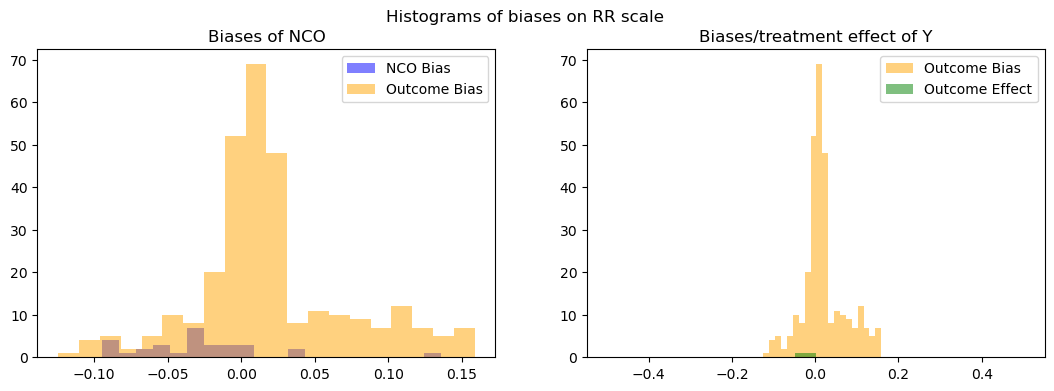

In [24]:
# Plot the true treatment effects and true biases
fig, axs = plt.subplots(1, 2, figsize=(13, 4))
axs[0].hist(np.log(bias_N), bins=20, color='blue', alpha=0.5, label='NCO Bias')
axs[0].hist(np.log(bias_Y_true), bins=20, color='orange', alpha=0.5, label='Outcome Bias')
axs[0].set_title('Biases of NCO')
axs[0].legend()
axs[1].hist(np.log(bias_Y_true), bins=20, color='orange', alpha=0.5, label='Outcome Bias')
axs[1].hist(np.log(effect_Y_true[0]), bins=20, color='green', alpha=0.5, label='Outcome Effect')
axs[1].set_title('Biases/treatment effect of Y')
axs[1].legend()
fig.suptitle('Histograms of biases on RR scale')
plt.show()

In [21]:
# Define function for statistics: s.e. for the biases
def get_boostrap_rd(indices, ncos, treatment, n):
    b_ncos = ncos[indices, :]
    b_treatment = treatment[indices]
    b_bias = []
    for i in range(n-1):
        for j in range(i+1, n):
            b_bias.append(np.mean(b_ncos[b_treatment==j,:], axis=0) - np.mean(b_ncos[b_treatment==i,:], axis=0))
    return np.array(b_bias).transpose()

def get_boostrap_rr(indices, ncos, treatment, n):
    b_ncos = ncos[indices, :]
    b_treatment = treatment[indices]
    b_bias = []
    for i in range(n-1):
        for j in range(i+1, n):
            b_bias.append(np.mean(b_ncos[b_treatment==j,:], axis=0) / np.mean(b_ncos[b_treatment==i,:], axis=0))
    return np.array(b_bias).transpose()

# Set the number of bootstrap samples
n_bootstrap = 100
# Create random sample with replacement of row indinces
b_indices = np.random.choice(range(n), size=(n_bootstrap, n), replace=True)
# Apply statistics to bootstrapped samples
b_bias = np.apply_along_axis(get_boostrap_rr, axis=1, arr=b_indices, ncos=N, treatment=A_obs, n=n_a)
# Standard deviation on the log risk ratio scale
b_bias = np.log(b_bias) 
# Calculate s.e. of statistics in bootstrap samples
se_bias_N = np.std(b_bias, axis=0, ddof=1)
# Calculate covariance matrix of bootstrap samples
cov_bias_N = np.cov(b_bias[:,:,0], rowvar=False)

In [16]:
# plt.imshow(cov_bias_N, cmap='viridis', interpolation='nearest')
# plt.title("Sample covariance of the NCOs bias estimates")
# plt.show()

In [26]:
# Convert matrix of biases to dataframe
data_columns = ['setting_' + str(i) for i in range(K)]
data_index = ['nco_' + str(i) for i in range(I)]
data = pd.DataFrame(np.log(bias_N), columns=data_columns) # bias is on RR scale
data['nco'] = data_index
data_long = pd.melt(data,
                    id_vars=['nco'],
                    value_vars=data_columns, 
                    var_name='setting', value_name='bias')
data_long['se'] = se_bias_N.flatten('F')
# data_long['true_bias'] = np.log(bias_N_true).flatten('F') # bias is on RR scale
print(data_long.head(3))

     nco    setting      bias        se
0  nco_0  setting_0 -0.091382  0.139626
1  nco_1  setting_0 -0.070520  0.082969
2  nco_2  setting_0  0.135725  0.055989


In [18]:
# Define the correct delta: all zero because U has an effect on each NCO
true_delta = 1*(np.isclose(np.log(bias_N_true), 0, atol=1e-02))
# True scenario mean bias
true_beta = np.abs(np.log(bias_N_true[true_delta==0])).mean(axis=0)
# Define the correct M: sign of the effect of U on NCOs
true_M = (np.sign(np.log(bias_N_true)) + 1) // 2
print(true_delta.mean())
print(true_M.mean())
print(true_beta)

0.06666666666666667
0.23333333333333334
0.04327174416324663


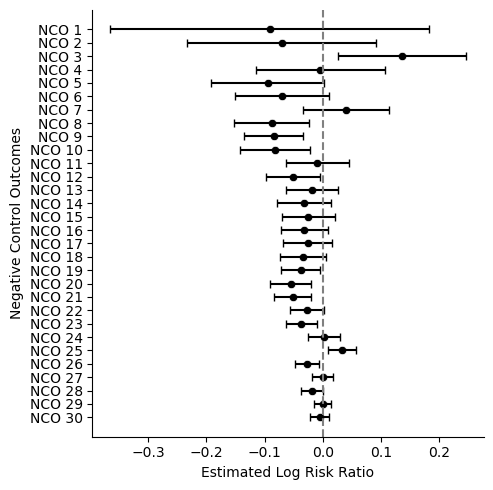

In [27]:
# Initialize a facet grid plot
g = sns.FacetGrid(data_long, col='setting', height=5, aspect=1)

# Add verticle blue line at true mean bias
# axes = g.axes[0]
# for ax, muk in zip(axes, [true_beta]):
#     ax.axvline(muk, ls='--')
#     ax.axvline(-muk, ls='--')

# Create the scatter plot of true bias in blue
# g.map(sns.scatterplot, 'true_bias', 'nco', alpha=0.75, color='blue', s=100)

# Create the scatter plot of the simulated data
g.map(sns.scatterplot, 'bias', 'nco', alpha=1, color='black')

# Function to add error bars
def add_error_bars(x, y, error, **kwargs):
    data = kwargs.pop("data")
    ax = plt.gca()
    for i, (_, row) in enumerate(data.iterrows()):
        ax.errorbar(row['bias'], row['nco'], xerr=1.96*row['se'], fmt='none', ecolor='black', capsize=3)
        
def replace_subtitle(x, y, title='', **kwargs):
    data = kwargs.pop("data")
    ax = plt.gca()
    ax.set_title(title)

# Add error bars faceted by 'type'
g.map_dataframe(add_error_bars, 'bias', 'nco', 'se')

# Remove title
g.map_dataframe(replace_subtitle, 'bias', 'nco', '')

# Add verticle line at 0.0
g.refline(x=0.0)

# Change axis labels
g.set_axis_labels("Estimated Log Risk Ratio", "Negative Control Outcomes")

# Change x ticks label
g.set_yticklabels(['NCO ' + str(i+1) for i in range(I)])

# Save plot to pdf
plt.savefig("data-negligible-30nco.pdf", format="pdf", bbox_inches="tight")

# Show the plot
plt.show()

## Fit the model using different choices of hyperparams for the prior

In [28]:
# Set parameters for fitting models
n_samples = 2000
n_tune = 20000
n_chains = 4

#### Specifying proportions (close to correct)

In [21]:
# # Intialize model with phi_d and phi_m closed to the true values
# model_cor = get_model_unconstrained(np.log(bias_N), se_bias_N, 
#                                     phi_d=true_delta.mean(), 
#                                     phi_m=true_M.mean(),
#                                     alpha_sigma=1,
#                                     nu=0, tau=100
#                                    )
# with model_cor:
#     # MCMC sampling
#     trace_cor = pm.sample(n_samples, tune=n_tune, chains=n_chains, 
#                           target_accept=0.95, random_seed=RANDOM_SEED)

In [22]:
# pm.model_to_graphviz(model_cor)

In [23]:
# # Convergence diagnostics, requires multiple chains
# az.summary(trace_cor, var_names=['beta', 'sigma']).round(3)
# # No convergence for beta because the posterior is bimodal (invariance in sign)

In [24]:
# # Diagnose convergence by plotting posterior density and trace plots
# az.plot_trace(trace_cor, var_names=["beta", "sigma", "slap", "delta"]); # expected magnitude of the bias in each treatment contrast

# # Plot individual posterior density and true values written in orange
# az.plot_posterior(trace_cor, var_names="beta", ref_val=true_beta.round(2).tolist());
# az.plot_posterior(trace_cor, var_names=["delta", 'm'], 
#                   ref_val=np.concatenate((true_delta[:,0], true_M[:,0])).astype(int).tolist()
#                  );

#### Uninformative hierarchical priors

<!-- $$u_M = 10\phi_M, u_\delta = 10\phi_\delta$$
$$v_M = 10-u_M, v_\delta = 10-u_\delta$$ -->

$$u_M = 1, u_\delta = 1$$
$$v_M = 1, v_\delta = 1$$

In [30]:
# RR when lRR is 2 s.d. away from 0
sd = 0.5
np.exp(2*sd)
vr = np.var(np.log(bias_N))
vr

0.0020967722800975083

In [31]:
# Set informed hyperparameters on prior for delta and m
model_hp = get_model_unconstrained(np.log(bias_N), se_bias_N, 
                                   alpha_d=1, beta_d=1, # 1/3 of estiamtes are not statistically significant
                                   alpha_m=1, beta_m=1, # 1/2 of estimates are positive
                                   # variance in data is 0.025, Pr(sigma^2 <= 0.025) = 0.95
                                   alpha_sigma=3.35, beta_sigma=0.03,
                                   nu=0, tau=vr) # 95percent that bias in RR between 0.36-2.7
# model_hp = get_model_unconstrained(np.log(bias_N), se_bias_N, 
#                                    alpha_d=1, beta_d=1, alpha_m=1, beta_m=1,
#                                    alpha_sigma=1, 
#                                    nu=0, tau=100
#                                   )
with model_hp:
    # MCMC sampling
    trace_hp = pm.sample(n_samples, tune=n_tune, chains=n_chains, 
                         target_accept=0.97, random_seed=RANDOM_SEED)

/Users/phucnguyen/miniconda3/envs/pymc_env/lib/python3.11/site-packages/multipledispatch/dispatcher.py:27: AmbiguityWarning: 
Ambiguities exist in dispatched function _unify

The following signatures may result in ambiguous behavior:
	[ConstrainedVar, Var, Mapping], [object, ConstrainedVar, Mapping]
	[object, ConstrainedVar, Mapping], [ConstrainedVar, Var, Mapping]
	[object, ConstrainedVar, Mapping], [ConstrainedVar, object, Mapping]
	[ConstrainedVar, object, Mapping], [object, ConstrainedVar, Mapping]


Consider making the following additions:

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)
  warn(warning_text(dispatcher.name, ambiguities), AmbiguityWarning)
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [phi_d, phi_m, beta, sigma, slap]
>BinaryGibb

Sampling 3 chains for 20_000 tune and 2_000 draw iterations (60_000 + 6_000 draws total) took 338 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [27]:
# Convergence diagnostics, requires multiple chains
az.summary(trace_hp, var_names=['beta', 'sigma', 'phi_d', 'phi_m']).round(3)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[setting_0],0.012,0.033,-0.051,0.058,0.004,0.003,94.0,571.0,1.03
sigma[setting_0],0.004,0.001,0.002,0.006,0.000,0.000,3544.0,4211.0,1.00
phi_d,0.165,0.110,0.000,0.357,0.004,0.003,702.0,2443.0,1.00
phi_m,0.364,0.352,0.000,0.967,0.045,0.032,86.0,415.0,1.03


/Users/phucnguyen/miniconda3/envs/pymc_env/lib/python3.11/site-packages/arviz/plots/plot_utils.py:271: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (60) in plot_posterior, generating only 40 plots
  warnings.warn(


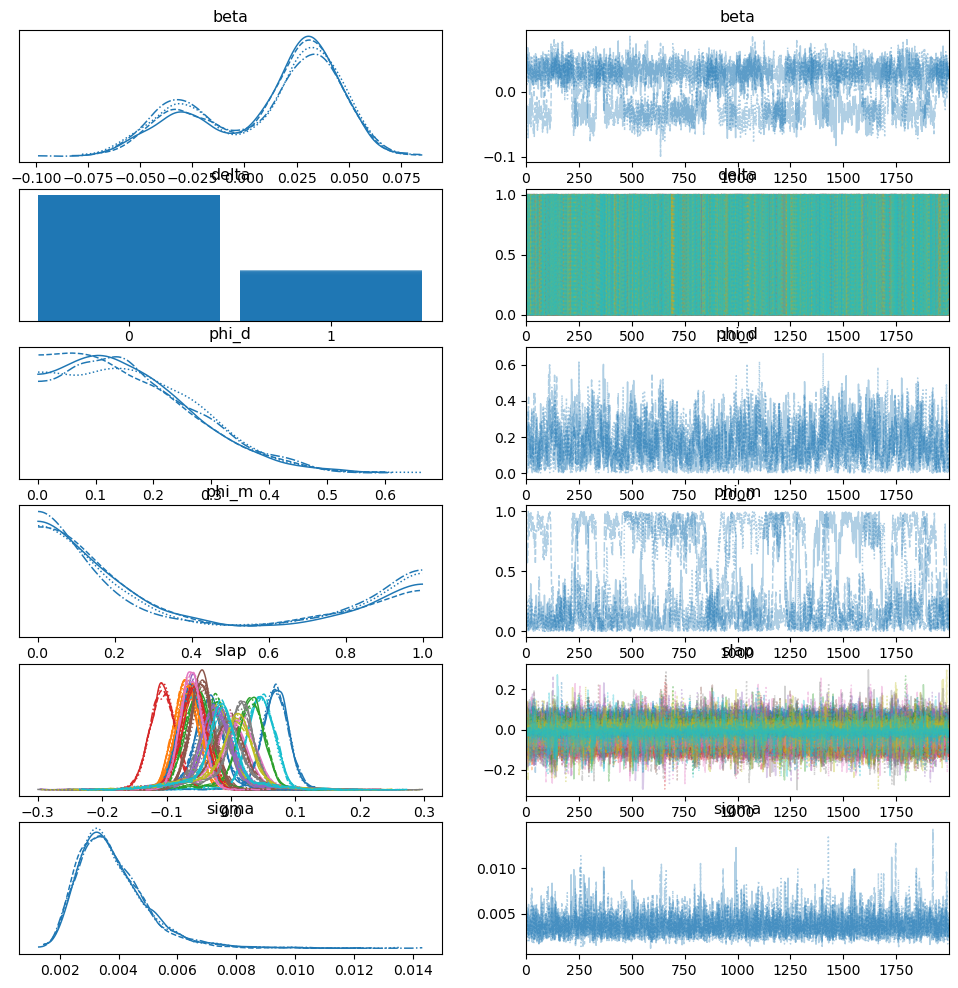

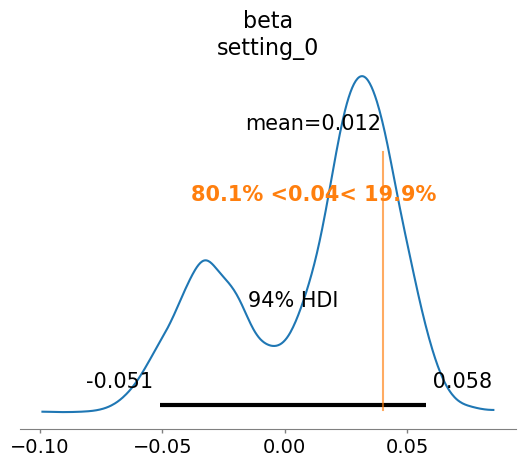

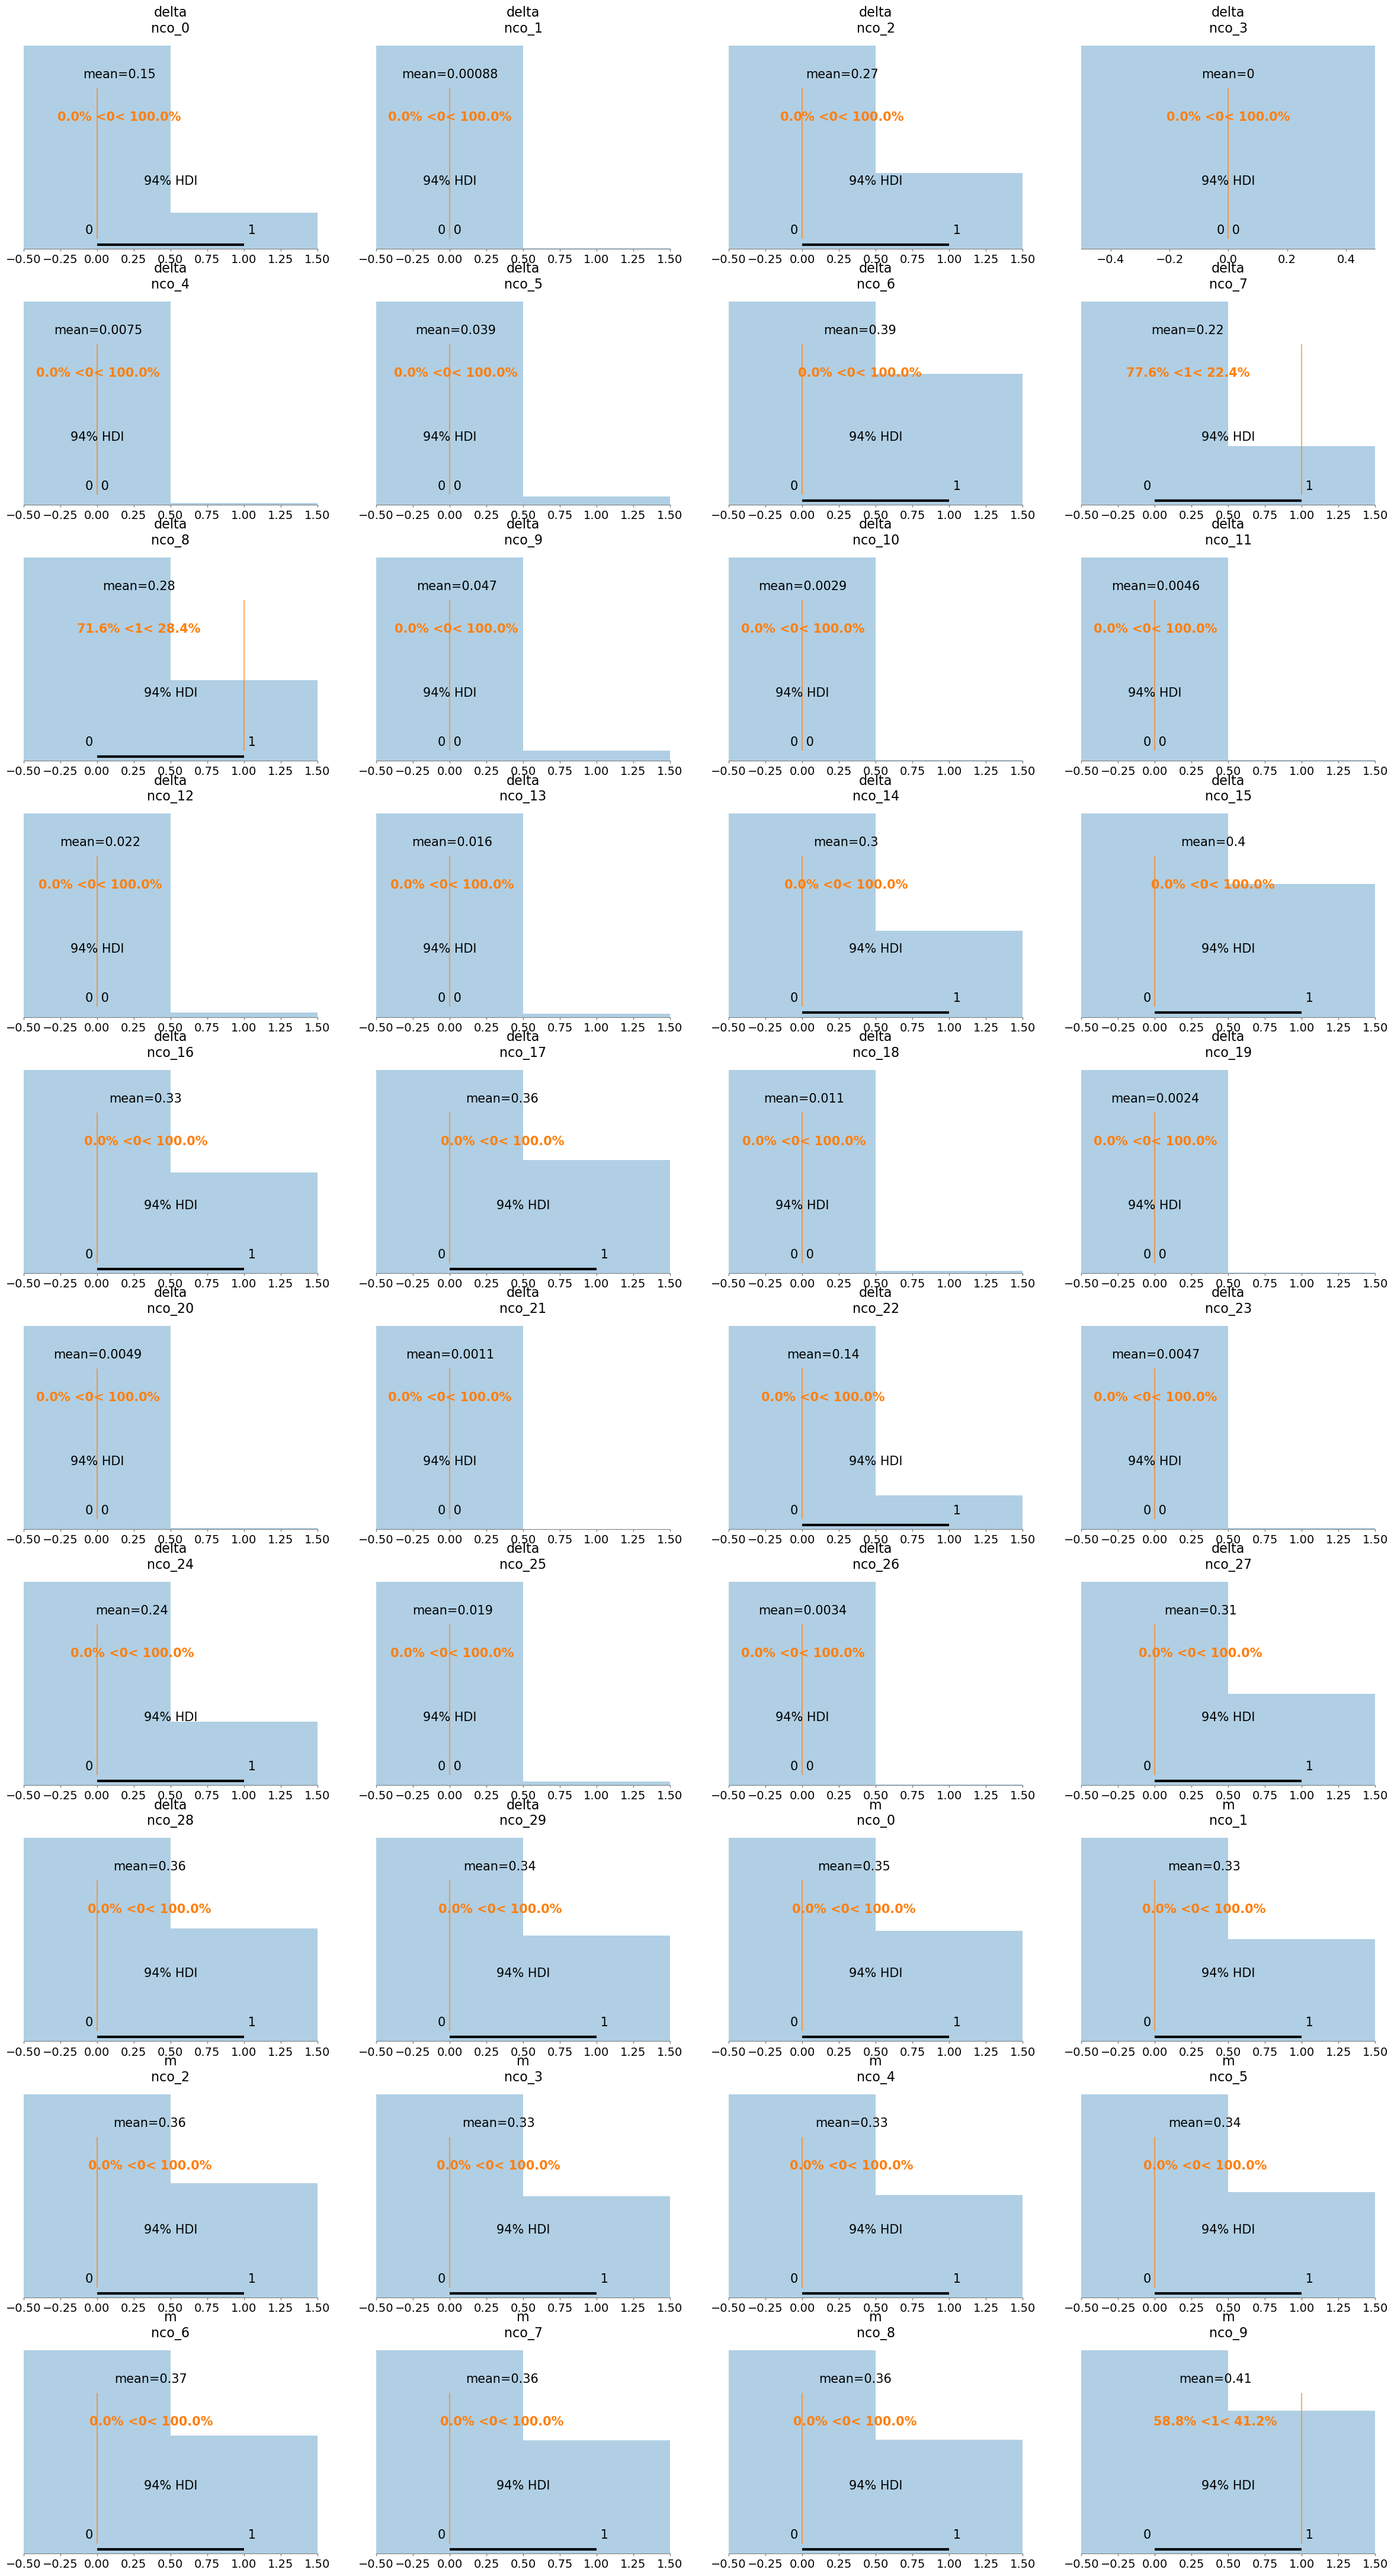

In [28]:
# Diagnose convergence by plotting posterior density and trace plots
az.plot_trace(trace_hp, var_names=["beta", 'delta', 'phi_d', 'phi_m', 'slap', 'sigma']); # expected magnitude of the bias in each treatment contrast

# Plot individual posterior density and true values written in orange
az.plot_posterior(trace_hp, var_names="beta", ref_val=true_beta.round(2).tolist());
az.plot_posterior(trace_hp, var_names=["delta", "m"], 
                  ref_val=np.concatenate((true_delta[:,0], true_M[:,0])).astype(int).tolist()
                 );

## Posterior predictive

In [29]:
# Predict the absolute value of the bias in Y
# For each MCMC iteration: 
# 1. simulate \delta_Y| \phi_d 
# 2. S_Yk|\delta_Y, \beta_k, \sigma_k, m_Y = 1 for all K
num_samps = n_samples
samps_hp = az.extract(trace_hp, var_names=["phi_d", 'beta', 'sigma'], num_samples=num_samps).to_dataframe()
samps_hp = samps_hp.drop(['draw', 'chain'], axis=1)
samps_hp = samps_hp.reset_index()
samps_hp.sort_values(by=['chain', 'draw', 'setting'], inplace=True)
samps_hp['delta_y'] = np.repeat(np.random.binomial(1, samps_hp.groupby(['draw', 'chain'])['phi_d'].min()), K)
samps_hp['slap_y'] = np.random.normal(np.abs(samps_hp['beta']), np.sqrt(samps_hp['sigma']), len(samps_hp))
samps_hp['slap_y'] = np.abs(samps_hp.slap_y)
samps_hp['bias_posterior'] = (1-samps_hp['delta_y'])*samps_hp['slap_y']
print(samps_hp.head(5))

      chain  draw    setting     phi_d      beta     sigma  delta_y    slap_y  \
1267      0     3  setting_0  0.229167  0.046338  0.003433        0  0.043894   
947       0     5  setting_0  0.152534  0.049295  0.003341        0  0.045600   
411       0     7  setting_0  0.259377  0.048401  0.003529        0  0.048255   
1835      0     9  setting_0  0.130001  0.028128  0.003816        0  0.028590   
1049      0    15  setting_0  0.176498  0.059838  0.003335        0  0.054115   

      bias_posterior  
1267        0.043894  
947         0.045600  
411         0.048255  
1835        0.028590  
1049        0.054115  


In [30]:
# # Predict the absolute value of the bias in Y
# # For each MCMC iteration: simulate \delta_Y| \phi_d => S_Yk|\delta_Y, \beta_k, \sigma_k for all K => ATE = ATE_obs - S_Yk
# samps_cor = az.extract(trace_cor, var_names=['beta', 'sigma'], num_samples=num_samps).to_dataframe()
# samps_cor = samps_cor.drop(['draw', 'chain'], axis=1)
# samps_cor = samps_cor.reset_index()
# samps_cor.sort_values(by=['chain', 'draw', 'setting'], inplace=True)
# samps_cor['phi_d'] = true_delta.mean()+0.03
# samps_cor['delta_y'] = np.repeat(np.random.binomial(1, samps_cor.groupby(['draw', 'chain'])['phi_d'].min()), K)
# samps_cor['slap_y'] = np.random.normal(np.abs(samps_cor['beta']), samps_cor['sigma'], len(samps_cor))
# samps_cor['slap_y'] = np.abs(samps_cor.slap_y)
# samps_cor['bias_posterior'] = (1-samps_cor['delta_y'])*samps_cor['slap_y']
# print(samps_cor.head(3))


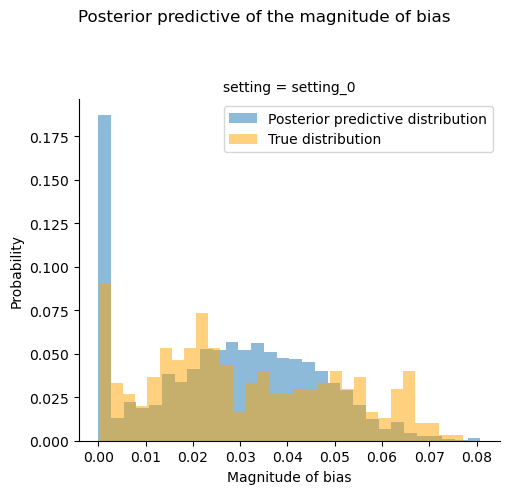

In [37]:
from scipy.stats import gaussian_kde

# Define truth
truth = np.abs(np.log(bias_Y_true[:, 0]))
# Compute kernel density for plotting
truth_pdf = gaussian_kde(truth)
xs = np.linspace(0,0.1,100)

# Define weights so that the histogram bar at zero reflects the probability that the bias is zero
weights = np.ones(num_samps)/float(num_samps)

# Create a FacetGrid with histograms
data_list = [samps_hp, 
#              samps_cor
            ]
plot_names = ["Posterior predictive of the magnitude of bias"
#               'Group Mean Model with Hierarchical Priors',
#               'Group Mean Model with Fixed phi_delta'
             ]
for dat, title in zip(data_list, plot_names):
    g = sns.FacetGrid(dat, col='setting', height=5, aspect=1)
        
    g.map(plt.hist, 'bias_posterior', 
          bins=30, alpha=0.5, 
          weights=weights,
          label='Posterior predictive distribution'
#         edgecolor='k', range=(-0.01, 0.1)
         )

#     # Add vertical lines at truth values
#     for ax, setting in zip(g.axes.flat, g.col_names):
#         ax.axvline(truth, color='red', linestyle='--', label=f'True bias = {round(truth, 2)}')
#         ax.legend() 
#         # Remove title
#         ax.set_title('')
    # Add density of true biases
    for ax, setting in zip(g.axes.flat, g.col_names):
#         ax.plot(xs, truth_pdf(xs) , color='orange', label='True bias distribution')
        ax.hist(truth, weights=np.ones(n_y)/float(n_y), 
                bins=30, color='orange', alpha=0.5, 
                label='True distribution')
        ax.legend()

    # Add title
    g.fig.subplots_adjust(top=0.8) # adjust the Figure in rp
    g.fig.suptitle(title);
    
    # Change x axis label
    g.set_axis_labels("Magnitude of bias", "Probability")
    
    # Save plot to pdf
    plt.savefig("ppredictive-groupmean-negligible-30nco.pdf", format="pdf", bbox_inches="tight")


In [32]:
# Calculate the CI of the posterior predictive for non-zero biases.
ci95 = np.percentile(samps_hp.loc[samps_hp['delta_y'] == 0]['bias_posterior'].values,
              [2.5, 97.5])
print(ci95)
bias_tmp = np.log(bias_Y_true[:, 0])
bias_nonzero = bias_tmp[~np.isclose(bias_tmp, 0, atol=1e-02)]
print(np.mean((np.abs(bias_nonzero) >= ci95[0]) * (np.abs(bias_nonzero) <= ci95[1])))
print(np.mean( samps_hp.bias_posterior <= np.log(1.1))) # 1.1 is neglegible threshold
print(np.mean( truth <= np.log(1.1)))
# np.mean((np.abs(bias_Y_true[:, 1][theta_y.transpose() > 0]) >= ci95[0]) * (np.abs(bias_Y_true[:, 0][theta_y.transpose() > 0]) <= ci95[1]))

[0.00359562 0.06249707]
0.9
1.0
1.0


In [33]:
np.log(1.1)

0.09531017980432493

0.19931000000000001


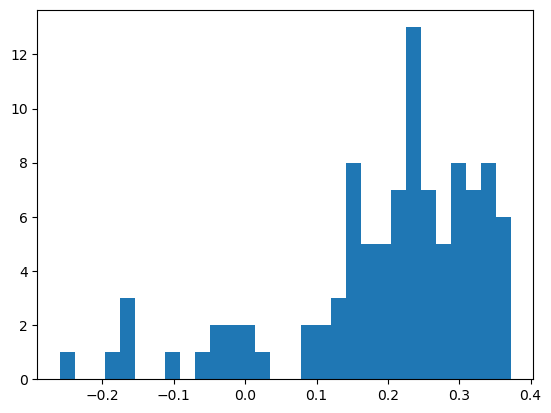

In [51]:
res = np.concatenate((np.load("../output/proceed-binary-biased-30a.npy"),
                      np.load("../output/proceed-binary-biased-30b.npy")[1:]))
print((res[0] - res[1:]).mean())
plt.hist(res[0] - res[1:], bins=30);

In [34]:
# # Calculate the coverage of the posterior predictive for non-zero biases.
# ci95 = np.percentile(samps_cor.loc[samps_hp['delta_y'] == 0]['bias_posterior'].values,
#               [2.5, 97.5])
# print(ci95)
# np.mean((np.abs(bias_Yo_true[theta_yo.transpose() > 0]) >= ci95[0]) * (np.abs(bias_Yo_true[theta_yo.transpose() > 0]) <= ci95[1]))
# np.mean((np.abs(bias_Yast_true[theta_yast.transpose() > 0]) >= ci95[0]) * (np.abs(bias_Yast_true[theta_yast.transpose() > 0]) <= ci95[1]))

## Extra functions

In [35]:
# ate: I \times K matrix of ATE estimates
# se: I \times K matrix of s.e. of the ATE estimates
# phi_d, phi_m: Empirical Bayes estimates of phi_d, phi_m; if None places hierarchical priors on them
# This parametrization is slow and produces a lot of divergences
def get_model(ate, se, x=None, phi_d=None, phi_m=None, nu=None, tau=None, alpha_d=1, beta_d=1, alpha_m=1, beta_m=1, m=None):
    # Set the number of NCOs
    I = ate.shape[0]
    
    # Set the number of scenarios/treatment contrasts
    K = ate.shape[1]

    # Declare the dimensions of the data and parameters. 
    # This helps with organizing the indices of the posterior samples
    coords_nco = ['nco_'+str(i) for i in range(I)]
    coords_setting = ['setting_'+str(i) for i in range(K)]
    coords = {'nco': coords_nco, 'setting': coords_setting}
    
    # Initialize a model
    model = pm.Model(coords=coords)
    with model:
        
        # State input data as shared variables. Not sure if this is neccesary, but seems to be recommended in the documentation
        Y_t = pm.MutableData('Y', ate, dims=('nco', 'setting'))
        Sigma_t = pm.MutableData('Sigma', se, dims=('nco', 'setting')) # TODO: update to include covariances
        x_t = pt.ones(I) #pm.MutableData('x', x, dims='nco') # currently fix to a vector of ones for group-mean estimation

        # Priors for unknown model parameters
        if nu is None:
            nu_t = pm.Normal('nu', mu=0, sigma=100)
        else:
            nu_t = nu
        if tau is None:
            tau_t = pm.HalfCauchy('tau', beta=1)
        else:
            tau_t = tau
        beta_t = pm.TruncatedNormal('beta', mu=nu_t, sigma=tau_t, lower=0, size=K, dims='setting')
        sigma_t = pm.HalfCauchy('sigma', beta=1, size=K, dims='setting')
        if phi_d is None: 
            phi_d_t = pm.Beta('phi_d', alpha=alpha_d, beta=beta_d)
        else:
            phi_d_t = phi_d
        if phi_m is None: 
            phi_m_t = pm.Beta('phi_m', alpha=alpha_m, beta=beta_m)
        else:
            phi_m_t = phi_m
        delta_t = pm.Bernoulli('delta', p=phi_d_t, size=I, dims='nco')
        if m is None:
            m_t = pm.Bernoulli('m', p=phi_m_t, size=I, dims='nco')
        else:
            m_t = pm.Data('m', m, dims='nco', mutable=False)
        # slap_t = pm.MatrixNormal('slap', mu=pt.outer(x_t, beta_t), rowcov=pt.eye(I), colcov=pt.diag(sigma_t**2), dims=('nco', 'setting'))
        # mu_t = pm.Deterministic('mu', pt.outer((1-delta_t)*(2*m_t-1), pt.ones(K))*slap_t, dims=('nco', 'setting'))
        slap_t = pm.Normal('slap', mu=pt.outer((2*m_t-1), beta_t), sigma=pt.outer(pt.ones(I), pt.sqrt(sigma_t)), dims=('nco', 'setting'))
        mu_t = pm.Deterministic('mu', pt.outer((1-delta_t), pt.ones(K))*slap_t, dims=('nco', 'setting'))
        
        # Likelihood model
        # TODO: make this a truncated likelihood -2 to 2?
        Y_obs = pm.Normal('Y_obs', mu=mu_t, sigma=Sigma_t, observed=Y_t, dims=('nco', 'setting'))

        # # Compound sampling step using MH + MWG + NUTS
        # steps = pm.CompoundStep([
        #                         pm.BinaryGibbsMetropolis([delta_t, m_t], transit_p=.42),
        #                         pm.Metropolis([beta_t, slap_t, sigma_t, tau_t])
        #                         ])
    
    return model